# Quik introduction to CFR

## import pkg
- torch_fix_seed : fix seed
- fetch_sample_data : sample data (Lalonde Job RCT data + non-RCT data)
- ipm_scores : for estimating MMD 
- CFR : CFR model
    

In [1]:
import warnings

warnings.filterwarnings("ignore")

import sys
import os
from tqdm import tqdm
from logging import getLogger, StreamHandler, FileHandler, Formatter, DEBUG, ERROR
from datetime import datetime
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

plt.style.use("ggplot")

sys.path.append(os.path.abspath("../"))
from src.utils import torch_fix_seed, fetch_sample_data, ipm_scores
from src.cfr import CFR

## set logger

In [2]:
logger = getLogger("run DFR")
logger.setLevel(DEBUG)
handler_format = Formatter("%(asctime)s - %(name)s - %(levelname)s - %(message)s")
stream_handler = StreamHandler()
stream_handler.setLevel(DEBUG)
stream_handler.setFormatter(handler_format)
file_handler = FileHandler(
   "../logs/"
    + "cfr"
    + "-"
    + "{:%Y-%m-%d-%H:%M:%S}.log".format(datetime.now()),
    "a",
)
file_handler.setLevel(DEBUG)
file_handler.setFormatter(handler_format)
logger.addHandler(stream_handler)
logger.addHandler(file_handler)
logger.debug(f"Start process...")

2022-06-13 13:44:47,032 - run DFR - DEBUG - Start process...


## set Hyperparameters
- alpha : α > 0 as Counterfactual Regression (CFR) and the variant without balance regularization (α = 0) as Treatment-Agnostic Representation Network (TARNet).
- split_outnet : Whether to split outnet or not

In [3]:
cfg = {
    "alpha": 10 ** 6,
    "lr": 1e-3,
    "wd": 0.5,
    "sig": 0.1,
    "epochs": 1000,
    "ipm_type": "mmd_lin",
    "repnet_num_layers": 3,
    "repnet_hidden_dim": 48,
    "repnet_out_dim": 48,
    "repnet_dropout": 0.145,
    "outnet_num_layers": 3,
    "outnet_hidden_dim": 32,
    "outnet_dropout": 0.145,
    "gamma": 0.97,
    "split_outnet": True,
}

## data loading & fixed random seed

In [4]:
(dataloader, X_train, y_train, t_train, X_test, y_test, t_test,) = fetch_sample_data(
    random_state=2022,
    test_size=0.5,
    StandardScaler=False,
    data_path="../data/sample_data.csv",
)

In [5]:
torch_fix_seed()

## CFR fitting

In [6]:
model = CFR(in_dim=8, out_dim=1, cfg=cfg)

within_result, outof_result, train_mse, ipm_result = model.fit(
    dataloader, X_train, y_train, t_train, X_test, y_test, t_test, logger
)

2022-06-13 13:44:47,077 - run DFR - DEBUG -                           within sample,      out of sample
2022-06-13 13:44:47,077 - run DFR - DEBUG -            [Train MSE, IPM], [RMSE, ATT, ATE], [RMSE, ATT, ATE]
2022-06-13 13:44:47,117 - run DFR - DEBUG - [Epoch: 0] [86144454.667, 94.872], [9289.731, 5678.963, -2319.269], [10750.303, 7143.278, -3514.551] 
2022-06-13 13:44:49,294 - run DFR - DEBUG - [Epoch: 100] [52474660.667, 0.005], [7209.679, 3469.677, -1100.517], [8119.516, 3476.190, -2249.946] 
2022-06-13 13:44:51,373 - run DFR - DEBUG - [Epoch: 200] [45449040.000, 0.299], [6740.078, 1940.729, -789.806], [7649.789, 1964.060, -1848.557] 
2022-06-13 13:44:53,296 - run DFR - DEBUG - [Epoch: 300] [43761979.333, 0.075], [6546.220, 1937.146, -112.666], [7481.711, 1832.949, -1274.930] 
2022-06-13 13:44:55,255 - run DFR - DEBUG - [Epoch: 400] [43231680.000, 0.011], [6482.372, 1444.229, -254.629], [7583.326, 1960.223, -1340.922] 
2022-06-13 13:44:57,184 - run DFR - DEBUG - [Epoch: 500] [438

In [7]:
outof_result

{'ATE': -797.97626, 'ATT': 1753.5684, 'RMSE': 7709.32}

In [8]:
within_result

{'ATE': 220.717, 'ATT': 1517.9446, 'RMSE': 6304.4834}

## Visualization of Representation layer using t-sne

In [9]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=2022)

In [10]:
within_ipm = ipm_scores(model, X_train, t_train, sig=0.1)

In [11]:
X = X_train.cpu().detach().numpy()
y = y_train.cpu().detach().numpy()
t = t_train.cpu().detach().numpy()

X_rep = model.repnet(X_train)
_X_rep = X_rep.cpu().detach().numpy()

In [12]:
X_reduced = tsne.fit_transform(X)
X_rep_reduced = tsne.fit_transform(_X_rep)

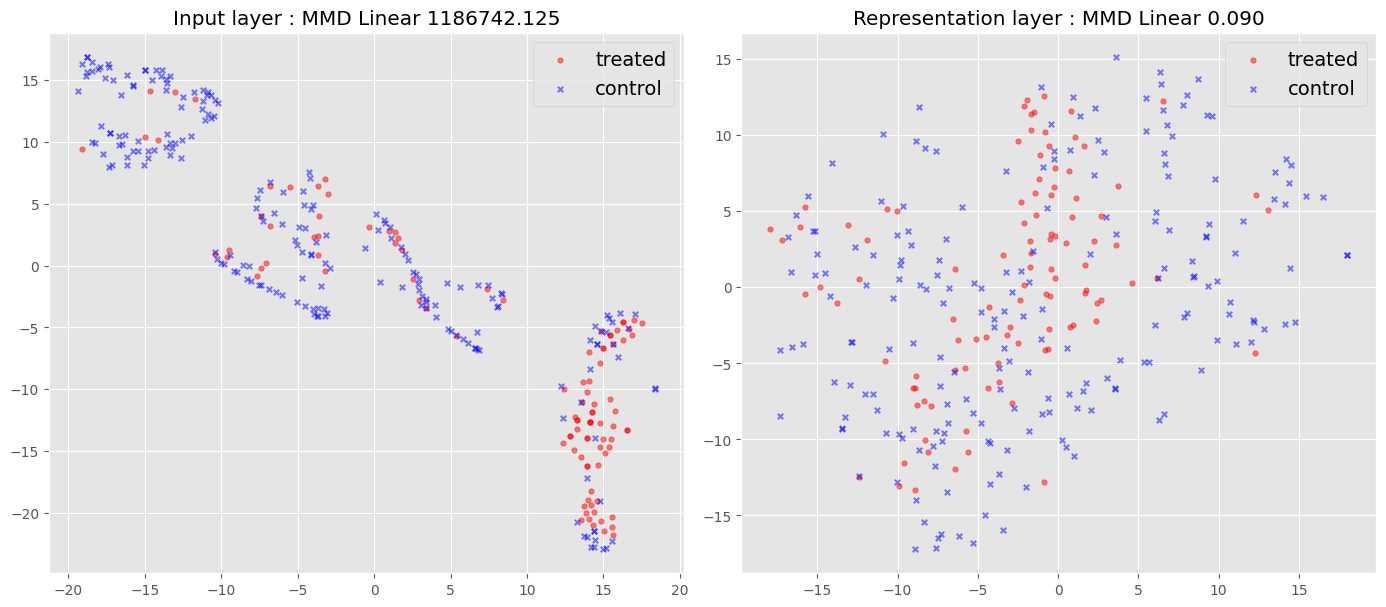

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))
plt.tight_layout()
axs[0].scatter(
    X_reduced[:, 0].reshape([-1, 1])[t == 1],
    X_reduced[:, 1].reshape([-1, 1])[t == 1],
    marker="o",
    s=15,
    alpha=0.5,
    c="red",
    label="treated",
)
axs[0].scatter(
    X_reduced[:, 0].reshape([-1, 1])[t == 0],
    X_reduced[:, 1].reshape([-1, 1])[t == 0],
    marker="x",
    s=15,
    alpha=0.5,
    c="blue",
    label="control",
)
axs[0].legend(loc="upper right", fontsize=14)
# axs[0].axis("off")

axs[0].set_title(f"Input layer : MMD Linear {within_ipm['ipm_lin_before'] :.3f}")

axs[1].scatter(
    X_rep_reduced[:, 0].reshape([-1, 1])[t == 1],
    X_rep_reduced[:, 1].reshape([-1, 1])[t == 1],
    marker="o",
    s=15,
    alpha=0.5,
    c="red",
    label="treated",
)
axs[1].scatter(
    X_rep_reduced[:, 0].reshape([-1, 1])[t == 0],
    X_rep_reduced[:, 1].reshape([-1, 1])[t == 0],
    marker="x",
    s=15,
    alpha=0.5,
    c="blue",
    label="control",
)
axs[1].legend(loc="upper right", fontsize=14)
# axs[1].axis("off")

axs[1].set_title(f"Representation layer : MMD Linear {within_ipm['ipm_lin'] :.3f}")
plt.show()